##### Copyright 2018 The TensorFlow Authors

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 定制化训练：基础

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/customization/custom_training"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 Tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/customization/custom_training.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/customization/custom_training.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />在 Github 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/customization/custom_training.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

在之前的教程中，我们讨论了自动差分，一个基本的机器学习模块。在这个教程中，我们将使用在之前介绍的 Tensorflow 基础语句实现简单的机器学习模型。

Tensorflow 也提供了高级神经网络 API（`tf.keras`），可以精简范例代码。我们强烈建议在神经网络方面的工作使用高级的 API。在这篇教程中，我们使用基本规则来训练神经网络，为以后打下牢固基础。

## 创建

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages

## 变量

Tensorflow 中的 tensor 是不可变无状态对象。机器学习模型需要可改变状态，比如模型训练和模型预测的代码是相同的，但变量值随着时间而不同（希望尽量小的 loss）。为了应对随着计算而改变的状态，可以利用 Python 的状态可变性。

In [2]:
# 使用 python 状态
x = tf.zeros([10, 10])
# 等价于 x = x + 2, 不改变原本 x 的值
x += 2  
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow，拥有内建可变状态操作，比使用底层 Python 状态表示更常见的。比如，表示模型的权重，使用 TensorFlow 变量更方便高效。

变量是一个对象，这个对象存储着数值，当在 TensorFlow 计算中使用时，会隐式地读取这个存储的数值。有一些操作（`tf.assign_sub`, `tf.scatter_update` 等）会复制 TensorFlow 变量存储的数值。

In [3]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# 重新赋值
v.assign(3.0)
assert v.numpy() == 3.0

# 在 TensorFlow 操作中使用 `v`，比如  tf.square() 和重新赋值
v.assign(tf.square(v))
assert v.numpy() == 9.0

当计算梯度时，会自动跟踪使用变量的计算过程。用变量来表示向量时，TensorFlow 会默认使用稀疏更新，这样可以带来计算和存储高效性。

使用变量也是一种更快的提醒方式，就是代码的这部分是状态可变的。

## 示例：尝试一个线性模型

让我们来使用目前为止学到的概念---`Tensor`，`Variable`，和 `GradientTape`---来创建和训练一个简单的模型。一般需要下面这些步骤：

1. 定义模型
2. 定义损失函数
3. 获取训练数据
4. 通过训练数据运行模型，使用 "optimizer" 来调整变量以满足数据

在这个教程中，我们使用一个简单线性模型作为示例：`f(x) = x * W + b`，有2个变量- `W` 和 `b`。另外，我们会生成数据让训练好的模型满足 `W = 3.0` 和 `b = 2.0`。

### 定义模型

定义一个简单的类封装变量和计算

In [4]:
class Model(object):
    def __init__(self):
        # 初始化变量值为(5.0, 0.0)
        # 实际上，这些变量应该初始化为随机值
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### 定义损失函数

损失函数用来衡量在给定输入的情况下，模型的预测输出与实际输出的偏差。我们这里使用标准 L2 损失函数。

In [7]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

### 获取训练数据

我们来生成带噪声的训练数据。

In [8]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

在训练模型之前，我们来看看当前的模型表现。我们绘制模型的预测结果和训练数据，预测结果用红色表示，训练数据用蓝色表示。

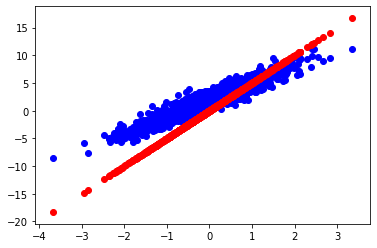

Current loss: 
8.538431


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

### 定义训练循环

我们已经定义了网络模型，并且获得了训练数据。现在对模型进行训练，采用[梯度下降](https://en.wikipedia.org/wiki/Gradient_descent)的方式，通过训练数据更新模型的变量（`W` 和 `b`）使得损失量变小。梯度下降中有很多参数，通过 `tf.train.Optimizer` 实现。我们强烈建议使用这些实现方式，但基于通过基本规则创建模型的精神，在这个特别示例中，我们自己实现基本的数学运算。

In [11]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    dW, db = t.gradient(current_loss, [model.W, model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [16]:
?tf.Variable.assign_sub

最后，我们对训练数据重复地训练，观察 `W` 和 `b` 是怎么变化的。

Epoch  0: W=5.00 b=0.00, loss=8.53843
Epoch  1: W=4.63 b=0.40, loss=5.89319
Epoch  2: W=4.33 b=0.72, loss=4.17184
Epoch  3: W=4.09 b=0.97, loss=3.05118
Epoch  4: W=3.89 b=1.17, loss=2.32124
Epoch  5: W=3.73 b=1.33, loss=1.84559
Epoch  6: W=3.60 b=1.46, loss=1.53548
Epoch  7: W=3.49 b=1.57, loss=1.33321
Epoch  8: W=3.40 b=1.65, loss=1.20121
Epoch  9: W=3.33 b=1.71, loss=1.11503


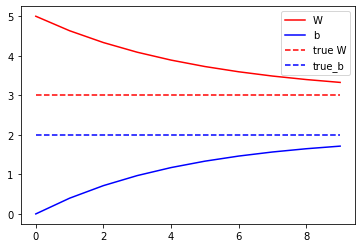

In [17]:
model = Model()

# 收集 W 和 b 的历史数值，用于显示
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)

    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# 显示所有
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()


## 下一步

在这个教程中，我们讨论了 `Variable`，而且创建和训练了一个简单的线性模型，使用了在此之前所学习的 TensorFlow 知识点。

理论上，掌握了 TensorFlow 这些知识点即可用于机器学习研究。实际上，采用高级的 API 比如 `tf.keras` 是更方便的，特别是神经网络，因为它提供了更高级别的内建模块（命名为 "layers"），可以保存和恢复状态，还有配套的损失函数和优化策略等。
